To run this sample, clone the [gcputils](https://github.com/aburdenko/gcputils) pacakge from my github and put it in a folder on your Google Drive named workspace/gcputils.

# Pre-reqs

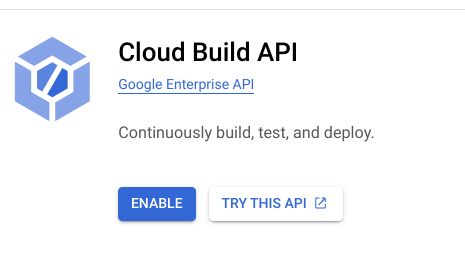

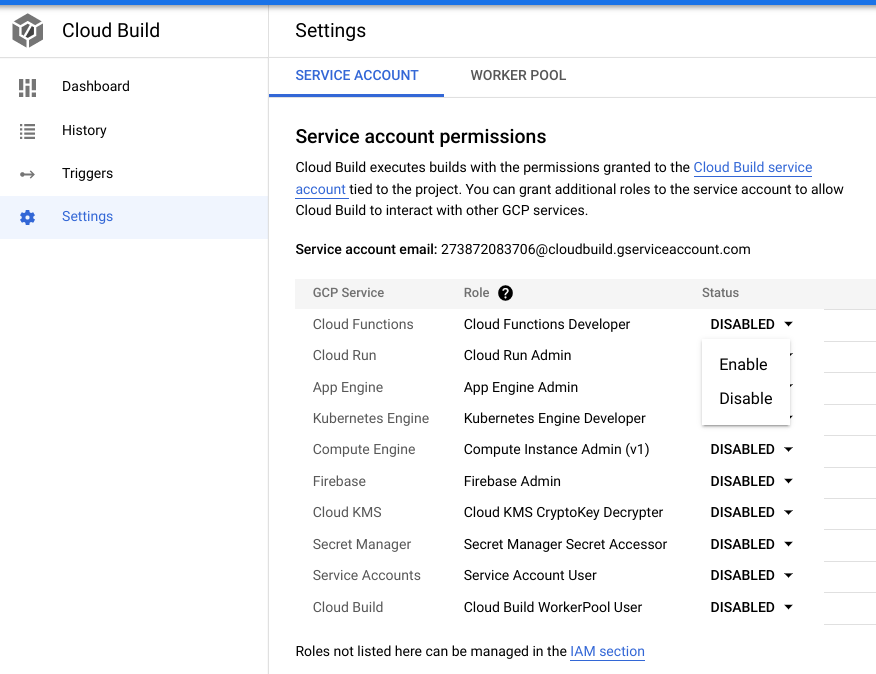

#Code

In [1]:
%reload_ext autoreload
%reload_ext google.cloud.bigquery
%autoreload 2


In [10]:
PROJECT_ID = "751469010911" # @param {type:"string"} <---CHANGE THESE
API_LOCATION = "us"  # @param {type:"string"} <---CHANGE THESE
DATASET_NAME = "" # @param {type:"string"} <---CHANGE THESE
TABLE_NAME = "" # @param {type:"string"} <---CHANGE THESE

BUCKET_NAME = "docai_nlp_demo" # @param {type:"string"} <---CHANGE THESE
REGION = "us-east4" # @param {type:"string"} <---CHANGE THESE
# SERVICE_ACCOUNT="REPLACE_ME@developer.gserviceaccount.com" #@param {type:"string"} <---CHANGE THESE
GOOGLE_APPLICATION_CREDENTIALS="/home/aburdenko/nlp-demo@concert-ai-nlp-demo.iam.gserviceaccount.com.json" #@param {type:"string"} <---CHANGE THESE
PROJECT_HOME="/home/aburdenko"
HOME_PATH='/home/aburdenko' # @param {type:"string"} <---CHANGE THESE

WKS_PATH=HOME_PATH+'/drive' 
LOCAL_LIB_PATH=HOME_PATH+'/.local/lib/python3.9/site-packages'
LIB_PATH=WKS_PATH+'/python3.9/site-packages'

%env WKS_PATH=$WKS_PATH
%env LOCAL_LIB_PATH=$LOCAL_LIB_PATH
%env LIB_PATH=$LIB_PATH


BUCKET_URI_PREFIX = '/'


GCS_INPUT_BUCKET_URI = 'gs://' + BUCKET_NAME + BUCKET_URI_PREFIX
INPUT_MIME_TYPE =  'application/pdf'
GCS_OUTPUT_BUCKET_URI = GCS_INPUT_BUCKET_URI
PROCESSOR_ID='c136dd1d86619949' #GeneticTests

GCS_OUTPUT_BUCKET=BUCKET_NAME
GCS_OUTPUT_URI_PREFIX=BUCKET_URI_PREFIX


import sys
IN_COLAB = 'google.colab' in sys.modules
%env IN_COLAB=$IN_COLAB
%env GOOGLE_APPLICATION_CREDENTIALS=$GOOGLE_APPLICATION_CREDENTIALS
%env BUCKET_NAME=$BUCKET_NAME
%env REGION=$REGION
%env PROJECT_HOME=$PROJECT_HOME
!gcloud config set project $PROJECT_ID -q


env: WKS_PATH=/home/aburdenko/drive
env: LOCAL_LIB_PATH=/home/aburdenko/.local/lib/python3.9/site-packages
env: LIB_PATH=/home/aburdenko/drive/python3.9/site-packages
env: IN_COLAB=False
env: GOOGLE_APPLICATION_CREDENTIALS=/home/aburdenko/nlp-demo@concert-ai-nlp-demo.iam.gserviceaccount.com.json
env: BUCKET_NAME=docai_nlp_demo
env: REGION=us-east4
env: PROJECT_HOME=/home/aburdenko
E0729 22:24:25.414327515   14680 backup_poller.cc:136]       Run client channel backup poller: {"created":"@1659133465.414237706","description":"pollset_work","file":"src/core/lib/iomgr/ev_epoll1_linux.cc","file_line":247,"referenced_errors":[{"created":"@1659133465.414231368","description":"Bad file descriptor","errno":9,"file":"src/core/lib/iomgr/ev_epoll1_linux.cc","file_line":732,"os_error":"Bad file descriptor","syscall":"epoll_wait"}]}
Updated property [core/project].


In [3]:

if IN_COLAB:
    from google.colab import auth
    auth.authenticate_user()

    from google.cloud.bigquery import magics
    import google.auth
    credentials, project = google.auth.default()

    magics.context.credentials = credentials

In [4]:
if IN_COLAB:
  from google.colab import files

  uploaded = files.upload()

  for fn in uploaded.keys():
    txt = "User uploaded file {name} with length {length} bytes".format( name=fn, length=len(uploaded[fn]))
    print( txt )
    
  import os  
  os.rename(f"/content/{fn}",'/content/service_account.json')

In [5]:
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)

In [6]:
import sys 

if WKS_PATH not in sys.path:  
  sys.path.insert(0, WKS_PATH)  

if LOCAL_LIB_PATH not in sys.path:
  sys.path.insert(0, LOCAL_LIB_PATH)


if LIB_PATH not in sys.path:
  sys.path.insert(0, LIB_PATH)

if '.' not in sys.path:
  sys.path.insert(0, '.')  


print(sys.path)

['.', '/home/aburdenko/drive/python3.9/site-packages', '/home/aburdenko/drive', '/home/aburdenko/drive/nlpdemo/notebooks', '/google/devshell/editor/theia/plugins/vscode-python/extension/pythonFiles', '/google/devshell/editor/theia/plugins/vscode-python/extension/pythonFiles', '/google/devshell/editor/theia/plugins/vscode-python/extension/pythonFiles/lib/python', '/usr/lib/python39.zip', '/usr/lib/python3.9', '/usr/lib/python3.9/lib-dynload', '', '/home/aburdenko/.local/lib/python3.9/site-packages', '/usr/local/lib/python3.9/dist-packages', '/usr/lib/python3/dist-packages']


In [41]:
import re

from google.api_core.client_options import ClientOptions
from google.cloud import documentai_v1 as documentai
from google.cloud import storage

# TODO(developer): Uncomment these variables before running the sample.
PROJECT_ID = '751469010911'
LOCATION = 'us' # Format is 'us' or 'eu'
PROC_ID = 'c136dd1d86619949' # Create processor in Cloud Console
GCS_INPUT_URI = "gs://docai_nlp_demo/raw/" # Format: gs://bucket/directory/file.pdf
INPUT_MIME_TYPE = "application/pdf"
GCS_OUTPUT_BUCKET = "docai_nlp_demo" # Format: gs://bucket
GCS_OUTPUT_PREFIX = "/processed/" # Format: directory/subdirectory/

def batch_process_documents(
    project_id: str = PROJECT_ID,
    location: str = LOCATION,
    processor_id: str = PROC_ID,
    gcs_input_uri: str = GCS_INPUT_URI,
    input_mime_type: str = INPUT_MIME_TYPE,
    gcs_output_bucket: str = GCS_OUTPUT_BUCKET,
    gcs_output_uri_prefix: str = GCS_OUTPUT_PREFIX,
    timeout: int = 300,
):

    # You must set the api_endpoint if you use a location other than 'us', e.g.:
    opts = ClientOptions(api_endpoint=f"{location}-documentai.googleapis.com")

    client = documentai.DocumentProcessorServiceClient(client_options=opts)

    gcs_document = documentai.GcsDocument(
        gcs_uri=gcs_input_uri, mime_type=input_mime_type
    )

    # Load GCS Input URI into a List of document files
    #gcs_documents = documentai.GcsDocuments(documents=[gcs_document])
    #input_config = documentai.BatchDocumentsInputConfig(gcs_documents=gcs_documents)

    # NOTE: Alternatively, specify a GCS URI Prefix to process an entire directory
    #
    # gcs_input_uri = "gs://bucket/directory/"
    gcs_prefix = documentai.GcsPrefix(gcs_uri_prefix=gcs_input_uri)
    input_config = documentai.BatchDocumentsInputConfig(gcs_prefix=gcs_prefix)
    #

    # Cloud Storage URI for the Output Directory
    destination_uri = f"{gcs_output_bucket}/{gcs_output_uri_prefix}/"

    gcs_output_config = documentai.DocumentOutputConfig.GcsOutputConfig(
        gcs_uri=destination_uri
    )

    # Where to write results
    output_config = documentai.DocumentOutputConfig(gcs_output_config=gcs_output_config)

    # The full resource name of the processor, e.g.:
    # projects/project_id/locations/location/processor/processor_id
    # You must create new processors in the Cloud Console first
    name = client.processor_path(project_id, location, processor_id)

    request = documentai.BatchProcessRequest(
        name=name,
        input_documents=input_config,
        document_output_config=output_config,
    )

    # BatchProcess returns a Long Running Operation (LRO)
    operation = client.batch_process_documents(request)

    # Continually polls the operation until it is complete.
    # This could take some time for larger files
    # Format: projects/PROJECT_NUMBER/locations/LOCATION/operations/OPERATION_ID
    print(f"Waiting for operation {operation.operation.name} to complete...")
    operation.result(timeout=timeout)

    # NOTE: Can also use callbacks for asynchronous processing
    #
    # def my_callback(future):
    #   result = future.result()
    #
    # operation.add_done_callback(my_callback)

    # Once the operation is complete,
    # get output document information from operation metadata
    metadata = documentai.BatchProcessMetadata(operation.metadata)

    if metadata.state != documentai.BatchProcessMetadata.State.SUCCEEDED:
        raise ValueError(f"Batch Process Failed: {metadata.state_message}")

    storage_client = storage.Client()

    print("Output files:")
    # One process per Input Document
    for process in metadata.individual_process_statuses:
        # output_gcs_destination format: gs://BUCKET/PREFIX/OPERATION_NUMBER/INPUT_FILE_NUMBER/
        # The Cloud Storage API requires the bucket name and URI prefix separately
        matches = re.match(r"gs://(.*?)/(.*)", process.output_gcs_destination)
        if not matches:
            print(
                "Could not parse output GCS destination:",
                process.output_gcs_destination,
            )
            continue

        output_bucket, output_prefix = matches.groups()

        # Get List of Document Objects from the Output Bucket
        output_blobs = storage_client.list_blobs(output_bucket, prefix=output_prefix)

        # Document AI may output multiple JSON files per source file
        for blob in output_blobs:
            # Document AI should only output JSON files to GCS
            if ".json" not in blob.name:
                print(
                    f"Skipping non-supported file: {blob.name} - Mimetype: {blob.content_type}"
                )
                continue

            # Download JSON File as bytes object and convert to Document Object
            print(f"Fetching {blob.name}")
            document = documentai.Document.from_json(
                blob.download_as_bytes(), ignore_unknown_fields=True
            )

            # For a full list of Document object attributes, please reference this page:
            # https://cloud.google.com/python/docs/reference/documentai/latest/google.cloud.documentai_v1.types.Document

            # Read the text recognition output from the processor
            print("The document contains the following text:")
            print(document.text)


In [43]:
batch_process_documents()

Waiting for operation projects/751469010911/locations/us/operations/574650574316004529 to complete...


InvalidArgument: 400 Failed to process all documents.